In [1]:
import pandas as pd
import numpy as np
import os, sys
import random
from math import ceil
from matplotlib import pyplot as plt
import json
from IPython import display

In [2]:
#read in index file (created in previous script)
indices = pd.read_csv("../data/index_file.csv", index_col=[0], parse_dates=["Date Planted"], low_memory=False)
#read in genotype clustering file
geno_clusters = pd.read_csv("../data/Genotype_data/genotype_clusters_Guillaume_27Sept2019.csv")
print(len(indices))

116991


In [3]:
####create Historical data splits####
hist_indices = indices[indices["G2F"]==False].copy()
G2F_indices = indices[indices["G2F"]==True].copy()

#test set - years 2014-present for all counties, as well as G2F counties across all years
idx1=hist_indices[hist_indices["Year"]>2013].copy().index.tolist()
G2F_counties = (G2F_indices["State"]+G2F_indices["County"]).unique().tolist()
idx2 = hist_indices[(hist_indices["State"]+hist_indices["County"]).isin(G2F_counties)].index.tolist()
hist_test = indices.loc[sorted(list(set(idx1+idx2)))].copy()

#Val set - random 10% from samples not in test set
not_test = hist_indices[hist_indices.index.isin(hist_test.index.tolist())==False].index.tolist()
hist_val = random.sample(not_test,int(len(hist_indices)*0.1))
hist_val = indices.loc[sorted(hist_val)].copy()

#test set - everything not in test or validation set
hist_train = hist_indices[hist_indices.index.isin(hist_test.index.tolist()+hist_val.index.tolist())==False].copy()
print(len(hist_train), len(hist_val), len(hist_test))
print(str(round(100*len(hist_train)/len(hist_indices),1))+"%",
      str(round(100*len(hist_val)/len(hist_indices),1))+"%",
      str(round(100*len(hist_test)/len(hist_indices),1))+"%")
#sainity checks
#print([x for x in hist_test.index.tolist() if x in hist_train.index.tolist()])
#print([x for x in hist_test.index.tolist() if x in hist_val.index.tolist()])
hist_sets={"Historical":{"train": hist_train.index.tolist(),
                         "val": hist_val.index.tolist(),
                         "test": hist_test.index.tolist()}}

61830 7804 8406
79.2% 10.0% 10.8%


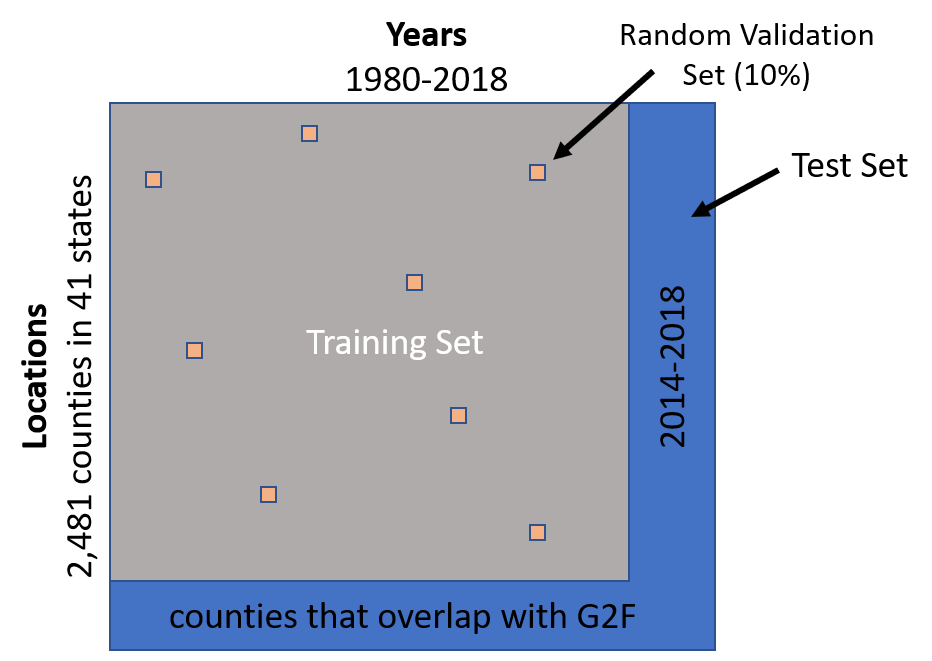

In [4]:
display.Image("../figures/Picture1.png")

In [5]:
#create G2F data splits

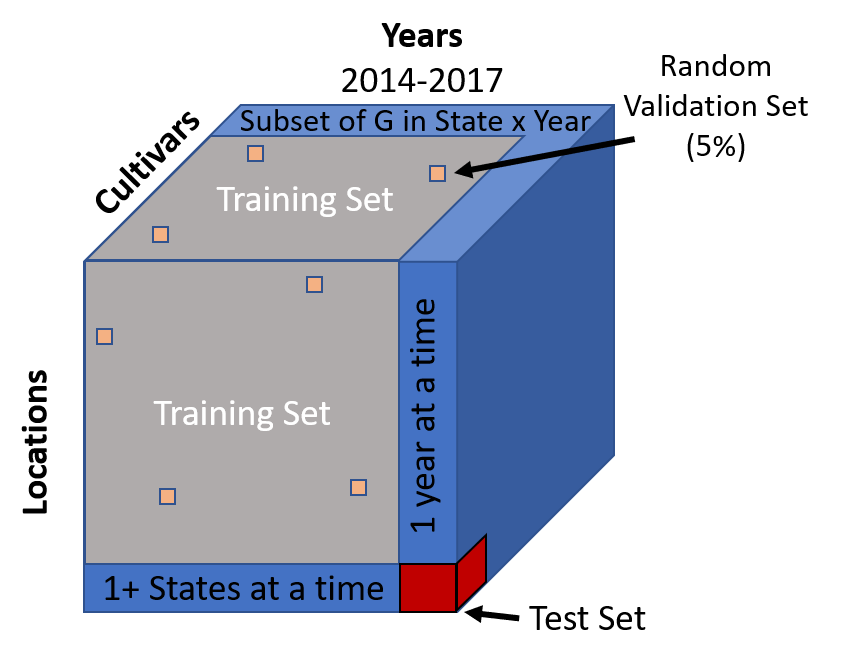

In [6]:
display.Image("../figures/Picture2.png")

In [7]:
def combine_locations(G2F_indices, geno_per_env_cutoff):
    #combine locations together so that every set of locations has at least a certian number of genotypes in it
    ###add column for merges. This will generally be the state but can be modified to put multiple states together
    G2F_indices["merged"]=G2F_indices["State"]+"@"+G2F_indices["Year"].astype(str)
    #geno_per_env_cutoff=0
    genos_per_state_year = G2F_indices.pivot_table(index=["merged","Year"], values="Pedigree", 
                                                   aggfunc=lambda x: np.count_nonzero(np.unique(x))).sort_values("Pedigree")
    genos_per_state_year.reset_index(inplace=True)
    print(len(genos_per_state_year))
    merged=[]
    #cycle thorugh combining the two environments within the same year that have the least number of genotypes
    while genos_per_state_year["Pedigree"].min()<geno_per_env_cutoff:
        for year in genos_per_state_year["Year"].unique():
            if genos_per_state_year[genos_per_state_year["Year"]==year]["Pedigree"].min()>=geno_per_env_cutoff: continue
            #print(year)
            to_merge=genos_per_state_year[genos_per_state_year["Year"]==year].sort_values(["Pedigree"]).iloc[:2]["merged"].tolist()
            G2F_indices["merged"] = G2F_indices["merged"].replace(to_merge[0],"-".join(to_merge))
            G2F_indices["merged"] = G2F_indices["merged"].replace(to_merge[1],"-".join(to_merge))
            merged = merged +to_merge
        genos_per_state_year = G2F_indices.pivot_table(index=["merged","Year"], values="Pedigree", 
                                                   aggfunc=lambda x: np.count_nonzero(np.unique(x))).sort_values("Pedigree")
        genos_per_state_year.reset_index(inplace=True)
    print(len(genos_per_state_year), len(merged))
    return genos_per_state_year, G2F_indices

In [8]:
def train_val_test_split_g_loc_year(G2F_indices, genos_per_state_year, geno_clusters):
    #hold out whole year (across all states) and state (across all years) and some proportion of genotypes it includes 
    min_genos_per_env = genos_per_state_year["Pedigree"].min() #this is essentially the test set size
    sets={} # will hold all train, val, and test set itterations
    hld_state_year_geno=[] #held out state-year-genotype info
    for year in G2F_indices["Year"].unique():
        for state in G2F_indices[G2F_indices["Year"]==year]["merged"].unique():  #State is actually a state (or combination of states at a single year)
            genos_in_state_year = G2F_indices[(G2F_indices["merged"]==state) &
                                              (G2F_indices["Year"]==year)]["Pedigree"].unique().tolist()
            geno_set=random.sample(genos_in_state_year,min_genos_per_env) #down sample genotypes randomly so all test sets have same number of genotypes
            test_set = G2F_indices[(G2F_indices["merged"]==state) & (G2F_indices["Year"]==year)].copy()
            test_set = test_set[test_set["Pedigree"].isin(geno_set)]
            test_set = test_set.sample(frac=1).drop_duplicates(["Pedigree"]) #drop replicates randomly so as to not favor on genotype over another (the original # of reps per genotype is different in each case)
            #hold out all genotypes sampled above as well as close relatives (those within the same cluster)
            hld_clusters = geno_clusters[geno_clusters["genotype"].isin(test_set["Pedigree"].unique())]["cluster"].unique().tolist()
            #genotypes to exclude from training set 
            non_train_genos = geno_clusters[geno_clusters["cluster"].isin(hld_clusters)]["genotype"].unique().tolist()
            train_set = G2F_indices[(G2F_indices["State"].isin(test_set["State"].unique().tolist())==False) &
                                        (G2F_indices["Year"]!=year)].copy()
            train_set = train_set[train_set["Pedigree"].isin(non_train_genos)==False]
            tmp_ids=sorted(random.sample(train_set.index.tolist(), int(0.05*len(train_set.index.tolist()))))
            val_set=train_set.loc[tmp_ids].copy()
            train_set=train_set[train_set.index.isin(tmp_ids)==False]
            #sanity checks
            if len(train_set[train_set["State"].isin(test_set["State"].unique().tolist())]) !=0:
                print("CONTAMINATED SETS: State")
            if len(train_set[train_set["Year"].isin(test_set["Year"].unique().tolist())]) !=0:
                print("CONTAMINATED SETS: Year")
            if len(train_set[train_set["Pedigree"].isin(test_set["Pedigree"].unique().tolist())]) !=0:
                print("CONTAMINATED SETS: Genotype")
            sets[state]={"train":train_set.index.tolist(),
                         "val":val_set.index.tolist(),
                         "test":test_set.index.tolist()}
            #record data for diagnostic purposes
            hld_state_year_geno.append([state, year, 1, len(geno_set),
                                            (len(geno_set)/len(G2F_indices["Pedigree"].unique()))*100,
                                            (len(non_train_genos)/len(geno_clusters))*100,
                                            len(train_set), len(val_set), len(test_set)])
    hld_state_year_geno = pd.DataFrame(hld_state_year_geno, columns=["State-Year(s)","Year", "Geno_set", "Genos_in_set",
                                                                     "Genos_in_set_%_of_all", "non-train_genos_%_all","Train", "Val","Test"])
    hld_state_year_geno["Train_as_%_of_T+V+T"]=(hld_state_year_geno["Train"]/
                                                (hld_state_year_geno["Train"]+hld_state_year_geno["Val"]+hld_state_year_geno["Test"]))*100
    hld_state_year_geno["Val_as_%_of_T+V+T"]=(hld_state_year_geno["Val"]/
                                                (hld_state_year_geno["Train"]+hld_state_year_geno["Val"]+hld_state_year_geno["Test"]))*100
    hld_state_year_geno["Test_as_%_of_T+V+T"]=(hld_state_year_geno["Test"]/
                                               (hld_state_year_geno["Train"]+hld_state_year_geno["Val"]+hld_state_year_geno["Test"]))*100
    hld_state_year_geno["Train_as_%_of_Tot"]=(hld_state_year_geno["Train"]/len(G2F_indices))*100
    hld_state_year_geno["Test_as_%_of_Tot"]=(hld_state_year_geno["Test"]/len(G2F_indices))*100
    hld_state_year_geno_stats = pd.DataFrame([hld_state_year_geno.mean(), hld_state_year_geno.min(),
                                              hld_state_year_geno.max()],
                                             index=["Mean","Min","Max"])[['Genos_in_set', 'Genos_in_set_%_of_all', "non-train_genos_%_all",
                                                                          'Train', 'Val', 'Test', 'Train_as_%_of_T+V+T',
                                                                          "Val_as_%_of_T+V+T", 'Test_as_%_of_T+V+T',
                                                                          'Train_as_%_of_Tot','Test_as_%_of_Tot']]
    hld_state_year_geno_stats["K_iterations"]=len(hld_state_year_geno)
    print(len(hld_state_year_geno), "Training, Validation, Testing set iterations.")
    return hld_state_year_geno, hld_state_year_geno_stats, sets

In [ ]:
genos_per_state_year, G2F_indices = combine_locations(G2F_indices, geno_per_env_cutoff=160)
hld_state_year_geno, hld_state_year_geno_stats, sets = train_val_test_split_g_loc_year(G2F_indices,
                                                                                       genos_per_state_year,
                                                                                       geno_clusters)
hld_state_year_geno_stats

In [8]:
#combine historical and G2F data sets into a single dictionary
sets.update(hist_sets)
len(sets)

50

In [9]:
#save sets to json file
with open('../data/Train_val_test_sets_13_Dec2019.json', 'w') as fp:
    json.dump(sets, fp)